## 04 中文分词与词元化

首先，我们读取从 `03 Data Augmentation.ipynb` 中保存的增强数据集，并将其拆分为训练集、验证集和测试集。


In [1]:
import pandas as pd

# 读取数据
df = pd.read_csv('data/weibo_augmented.csv', encoding='utf-8-sig')

df = df[["text", "sentiment_polarity"]]
print(f"数据: {len(df)} 行")
df.head()

数据: 391818 行


,text,sentiment_polarity
0,空心菜是世界上最好吃的青菜,1
1,下雪了？好美的雪啊,1
2,哈哈哈娱乐圈文必须有的环节之上综艺打电话环节，必给男主打电话,1
3,亚森发热 发热,0
4,人随春好，春与人宜。,1


### 标签映射

可以看到，数据集使用 `[-1, 0, 1]` 表示情感极性。

后续训练模型时会发现，反向传播时使用的损失函数（`NLLLoss` 或 `CrossEntropyLoss`）要求样本的标签为 `0 ~num_classes-1` 之间的整数，因此需要将情感标签从原始的 `[-1, 0, 1]` 映射到 `[0, 1, 2]`。

这里使用函数 `remap_labels` 来实现标签的映射。

In [2]:
import os
from pandas import DataFrame

def remap_labels(data: DataFrame, label_mapping={-1:0, 0:1, 1:2}):  #@save
    if 2 in data["label"].values:
        return data
    remapped_data = []
    for tokens, old_label in data.values:
        new_label = label_mapping.get(old_label, old_label)
        remapped_data.append((tokens, new_label))
    return DataFrame(remapped_data, columns=["text", "label"])

df = df.rename(columns={"sentiment_polarity": "label"})
df = remap_labels(df)
print(df['label'].value_counts())

label
2    167778
0    124334
1     99706
Name: count, dtype: int64


### 划分数据集
在机器学习任务中，通常需要将数据集划分为训练集、验证集和测试集，以便模型能够在不同的数据上进行训练和评估。

训练集用于模型的训练，验证集用于调参和选择最佳模型，测试集用于最终评估模型的性能。

`sklearn.model_selection` 模块提供了方便的函数 `train_test_split`，可以轻松地将数据集划分为不同的子集。

In [3]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_raw = DataFrame({"text": X_train, "label": y_train})
val_raw = DataFrame({"text": X_val, "label": y_val})
test_raw = DataFrame({"text": X_test, "label": y_test})

len(train_raw), len(val_raw), len(test_raw)


(274272, 58773, 58773)

接下来，我们要考虑文本数据的分词与词元化处理。


分词（Word Segmentation）是中文自然语言处理中的基础任务，旨在将连续的汉字序列切分成有意义的词语单元。与英文等语言不同，中文文本中词语之间没有明确的空格分隔符，这使得分词成为中文 NLP 任务中的一个关键步骤。

词元化（Tokenization）是将文本转换为模型可处理的数值形式的过程。对于基于词袋模型（Bag-of-Words）或词嵌入（Word Embeddings）的模型，词元化通常涉及将分词后的词语映射到唯一的整数索引，形成词汇表（Vocabulary）。

下面我们将逐步完成分词、构建词汇表以及词元化的过程。


### 分词（Word Segmentation）

我们使用 LTP 作为分词工具。LTP（Language Technology Platform，语言技术平台）是哈尔滨工业大学社会计算与信息检索研究中心（HIT-SCIR）历时多年研发的一整套高效、高精度的中文自然语言处理开源基础技术平台。相较于常用的分词工具如 Jieba，LTP 在分词方面各方面的表现均较为优秀，适合用于对文本进行高质量的分词处理。

In [4]:
from pandas import DataFrame

def segment_data(X, y, file_path='', batch_size=500):  #@save
    """
    分批处理数据以避免内存不足问题
    batch_size: 每批处理的数据量，默认1000条
    """
    if os.path.exists(file_path):
        print(f"文件 {file_path} 已存在，直接读取。")
        return load_data(file_path, sep='<sp>', is_segmented=True)
    if not isinstance(X, list):
        X = X.tolist()
    if not isinstance(y, list):
        y = y.tolist()
    
    from ltp import LTP
    ltp = LTP()

    segmented_data = []
    
    print(f"开始处理 {len(X)} 条数据，批大小: {batch_size}")
    
    if len(file_path) > 0:
        # 打开文件准备写入
        with open(file_path, 'w', encoding='utf-8') as f:
            # 分批处理
            for i in range(0, len(X), batch_size):
                batch_end = min(i + batch_size, len(X))
                batch_X = X[i:batch_end]
                batch_y = y[i:batch_end]
                
                print(f"正在处理第 {i//batch_size + 1} 批，数据范围: {i}-{batch_end-1}")
                
                # 对当前批次进行分词
                segment = ltp.pipeline(batch_X, tasks=['cws'], return_dict=False)[0]
                
                # 写入文件
                for sublist, label in zip(segment, batch_y):
                    segmented_data.append((sublist, label))
                    f.write('<sp>'.join(sublist) + ':' + str(label) + '\n')
                
                print(f"第 {i//batch_size + 1} 批处理完成")
    
    print("所有数据处理完成！")
    return DataFrame(segmented_data, columns=["text", "label"])

def load_data(  #@save
        file_path: str, 
        sep='', 
        is_segmented=False, 
        is_indexed=False) -> DataFrame:
    data = []
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            X, y = line.rsplit(':', 1)
            if is_segmented:
                X = [token.strip() for token in X.split(sep) if token.strip() != '']
            elif is_indexed:
                X = list(map(int, X.split(sep)))
            y = int(float(y))
            data.append((X, y))
    return DataFrame(data, columns=["text", "label"])


# 分批处理数据，使用较小的批大小以避免内存问题
print("开始处理训练集...")
train_seg = segment_data(X_train, y_train, 'data/train_segmented.txt', batch_size=500)

print("\n开始处理验证集...")
val_seg = segment_data(X_val, y_val, 'data/val_segmented.txt', batch_size=500)

print("\n开始处理测试集...")
test_seg = segment_data(X_test, y_test, 'data/test_segmented.txt', batch_size=500);

开始处理训练集...
文件 data/train_segmented.txt 已存在，直接读取。

开始处理验证集...
文件 data/val_segmented.txt 已存在，直接读取。

开始处理测试集...
文件 data/test_segmented.txt 已存在，直接读取。


### 构建词汇表（Vocabulary）

无论是使用深度学习还是使用传统的统计机器学习方法处理自然语言，都需要将输入的语言符号（通常为词元）映射为大于等于 0、小于词表大小的整数，该证书也被乘坐一个词元的索引值或下表。

下面，我们亲自动手实现一个 `Vocab` 类，实现词元和索引之间的相互映射。

In [5]:
from collections import defaultdict

class Vocab:
    def __init__(self, tokens=None) -> None:
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk"]
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx["<unk>"]

    @classmethod
    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
        
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() 
                        if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self) -> int:
        return len(self.idx_to_token)
    
    def __getitem__(self, token):
        """查找输入词元对应的索引值，若不存在，则返回<unk>的索引值（0）"""
        return self.token_to_idx.get(token, self.unk)
    
    def convert_tokens_to_ids(self, tokens):
        """查找一系列输入词元的索引值"""
        return [self[token] for token in tokens]
    
    def convert_ids_to_tokens(self, indices):
        """查找一系列输入索引值对应的词元"""
        return [self.idx_to_token[index] for index in indices]

def save_vocab(vocab: Vocab, file_path: str):
    with open(file_path, 'w', encoding='utf-8-sig') as f:
        f.write('\n'.join(vocab.idx_to_token))

def read_vocab(file_path: str) -> Vocab:
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        tokens = f.read().split('\n')
    return Vocab(tokens)

在实例化 `Vocab` 类创建词汇表对象前，我们需要解决两个重要的问题：

1. 应该在什么数据集上构建词汇表？
2. 如何设定类方法 `build` 中的最小词频参数 `min_freq`？

首先来看第1个问题。问题换言之，我们是应该使用训练集、验证集和测试集组成的整个大数据集上构建词汇表，还是仅使用训练集来构建词汇表？

在这里，我们采用仅使用训练集来构建词汇表的策略。原因有二：
- **防止数据泄漏（Data Leakage）**：使用验证集和测试集的数据来构建词汇表可能会导致模型在训练过程中“看到”这些数据，从而影响模型的泛化能力。为了确保模型的评估结果真实反映其在未见数据上的表现，应该避免在训练过程中使用验证集和测试集的信息。
- **模拟真实应用场景**：在实际应用中，模型通常只能访问训练数据，而无法预先了解未来的验证或测试数据。因此，仅使用训练集构建词汇表更符合实际应用场景，有助于提高模型在真实环境中的表现。

尽管也有一些研究称，同时使用验证集和测试集构建词表并不会导致数据泄露（因为词表作为统计资源，并不包含标签信息或特征分布信息），但为了尽可能模拟现实的应用场景，以及作为工业上的更常用策略，我们仍然仅使用训练集来构建词汇表。

接着是第2个问题，即如何设定最小词频参数 `min_freq`？

最小词频参数 `min_freq` 是构建词表时用来过滤低频词的重要参数，它将直接影响词表大小、模型的泛化能力和训练速度等。

具体而言，`min_freq` 的作用在于：只有当某个词出现次数大于等于 `min_freq` 时，才会被保留到词表中；否则将视为“低频词”，使用 `<unk>`（未知词）进行替代。

如果 `min_freq` 设置太小，优点在于能够最大程度保留词汇信息，缺点在于会导致词表过大，进而导致模型训练较慢，并且带来较大噪声；

相反，如果 `min_freq` 设置过大，优点在于能够显著减少词表大小，提高训练速度，缺点在于会丢失太多低频但重要的词，影响情感分类准确率。

关于 `min_freq` 的设置，可以参考下面的经验标准：
|数据量|推荐 `min_freq`|
|-|-|
|<1 万条文本|1|
|1~10 万条文本|2~3|
|10~100 万条文本|3~5|
|>100万条文本|5~10|

在前面的部分，我们已知训练集的大小约为 27 万条文本，因此推荐 `min_freq` 设置在 3~5 之间。

进一步地，我们可以通过观察词频分布与统计覆盖率的方法，更加科学与定量地确定 `min_freq` 的值。

首先，我们统计训练集中各词的词频分布情况，并绘制词频分布图。

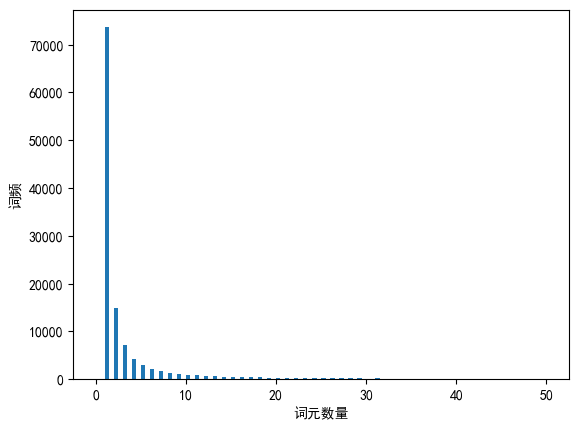

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

token_counts = Counter(token for text in train_seg["text"] for token in text)
freqs = list(token_counts.values())
plt.hist(freqs, bins=100, range=(0,50))
plt.xlabel('词元数量')
plt.ylabel('词频')
plt.show();

通过观察图中词频与词汇数量的关系，我们可以发现大部分词的词频较低，而少数高频词占据了大部分文本内容。这符合中文微博语料的长尾分布特性。

我们可以查看频率最高的前50个词元：

In [7]:
token_counts.most_common(50)

[('的', 145046),
 ('了', 106278),
 ('，', 94144),
 ('我', 91002),
 ('是', 47335),
 ('不', 44673),
 ('。', 44448),
 ('！', 40212),
 ('一', 36954),
 ('好', 32228),
 ('啊', 32084),
 ('在', 23140),
 ('就', 23030),
 ('都', 22217),
 ('想', 19811),
 ('你', 18948),
 ('有', 17781),
 ('要', 16599),
 ('吃', 16493),
 ('人', 16370),
 ('天', 15765),
 ('到', 15576),
 ('这', 14850),
 ('个', 14716),
 ('也', 14252),
 ('看', 13739),
 ('又', 13601),
 ('很', 13468),
 ('能', 13388),
 ('没', 12484),
 ('和', 12422),
 ('会', 12070),
 ('今天', 11830),
 ('一个', 11277),
 ('小', 11110),
 ('去', 11044),
 ('真', 11027),
 (',', 10775),
 ('太', 10658),
 ('上', 10623),
 ('还', 10612),
 ('自己', 10490),
 ('来', 10016),
 ('着', 8863),
 ('多', 8168),
 ('给', 8079),
 ('说', 7700),
 ('得', 7552),
 ('这个', 7503),
 ('爱', 7313)]

对高频词稍作分析：
- 出现标点符号：如 `，`、`。`、`！` 等
    - 对于分句作用的符号，如 `，`、`。`、`、` 等，对于情感表达的作用不大，可以考虑去除。
    - 对于表示情感的符号，如 `！`、`？` 等，可以考虑保留。
- 出现虚词，如 `的`、`了`、`在`
    - 尽管此类词语在语义上作用不大，但：
        - 对传统机器学习来说，可通过权重自动弱化
        - 对深度模型来说，它们的词嵌入会自动学到较弱权重
    - 因此考虑保留此类词语

接着，查看词元计数器中出现的所有标点符号：

In [8]:
import unicodedata

punct_tokens = [
    (t, freq) for t, freq in token_counts.items() 
    if all(unicodedata.category(ch).startswith('P') 
           for ch in t)]

punct_tokens

[('，', 94144),
 ('。', 44448),
 ('(', 2942),
 (')', 2932),
 ('！', 40212),
 ('？', 7211),
 ('_', 323),
 (',', 10775),
 ('!', 395),
 ('（', 4466),
 ('）', 3302),
 ('?', 2078),
 ('：', 5391),
 ('@', 1),
 (':', 450),
 ('#', 77),
 ('##', 3),
 ('###', 3),
 ('、', 583),
 ('"', 392),
 ('【', 502),
 ('】', 480),
 ('；', 174),
 ('...', 38),
 ('_______', 2),
 ('.', 59),
 ('《', 45),
 ('》', 45),
 ('___', 5),
 ('“', 36),
 ('”', 30),
 ('*', 1),
 ('[', 7),
 (']', 7),
 ('____', 3),
 (';', 15),
 ('§', 7),
 ('¶', 3),
 ('-', 37),
 ('\\', 1),
 ('__', 5),
 ('__________', 1),
 ('____________', 1),
 ('%', 2),
 ("'", 1),
 ('______', 1),
 ('___________', 1),
 ('（）', 1),
 ('..', 1)]

对标点符号的进一步分类与分析：
- 表示情感的符号：如 `！`、`？` 等，保留

- 分句符号：如 `，`、`。`、`；` 等，去除

- 结构性符号：如 `（`、`）`、`【`、`】` 等，去除

- 异常符号（人工添加线）：如 `_`、`__` 等，去除

因此，需要对一些标点符号进行过滤，去除不必要的标点符号。

在清洗分词数据集的同时，也需要将未分词的原始数据集中对应的数据一并清洗，以保证分词数据集与原始数据集的一一对应关系。

In [9]:
def clean_punct_synchronized(seg_data: DataFrame, raw_data: DataFrame):
    """同步清理分词数据和原始数据，确保删除的是相同的样本"""
    
    remove_punct = {'，', ',', '。', '；', ';',  '：', ':',
                     '"', '"', '"', '（', '）', '(', ')',  
                     '【', '】', '[', ']',  '《', '》', 
                     '#', '_'}
    
    cleaned_seg_data = []
    cleaned_raw_data = []
    removed_indices = []
    
    print(f"开始清理数据，原始长度: seg={len(seg_data)}, raw={len(raw_data)}")
    
    for i in range(len(seg_data)):
        seg_tokens = seg_data.iloc[i]['text']
        seg_label = seg_data.iloc[i]['label']
        raw_text = raw_data.iloc[i]['text'] 
        raw_label = raw_data.iloc[i]['label']
        
        # 清理分词数据中的标点符号
        cleaned_tokens = [token for token in seg_tokens if token not in remove_punct]
        
        # 检查清理后的文本是否过短
        if len(''.join(cleaned_tokens)) <= 3:
            removed_indices.append(i)
        else:
            cleaned_seg_data.append([cleaned_tokens, seg_label])
            cleaned_raw_data.append([raw_text, raw_label])
    
    cleaned_seg_df = pd.DataFrame(cleaned_seg_data, columns=["text", "label"])
    cleaned_raw_df = pd.DataFrame(cleaned_raw_data, columns=["text", "label"])
    
    print(f"清理完成，删除了 {len(removed_indices)} 个样本")
    print(f"清理后长度: seg={len(cleaned_seg_df)}, raw={len(cleaned_raw_df)}")
    
    return cleaned_seg_df, cleaned_raw_df, removed_indices


print("原始数据长度:")
print(f"train: seg={len(train_seg)}, raw={len(train_raw)}")
print(f"val: seg={len(val_seg)}, raw={len(val_raw)}")
print(f"test: seg={len(test_seg)}, raw={len(test_raw)}")

# 使用正确的方法同步清理数据
print("\n开始同步清理...")
train_seg_cleaned, train_raw_cleaned, train_removed_indices = clean_punct_synchronized(train_seg, train_raw)
val_seg_cleaned, val_raw_cleaned, val_removed_indices = clean_punct_synchronized(val_seg, val_raw)
test_seg_cleaned, test_raw_cleaned, test_removed_indices = clean_punct_synchronized(test_seg, test_raw)


print(f"\n最终数据长度:")
print(f"train: seg={len(train_seg_cleaned)}, raw={len(train_raw_cleaned)}")
print(f"val: seg={len(val_seg_cleaned)}, raw={len(val_raw_cleaned)}")
print(f"test: seg={len(test_seg_cleaned)}, raw={len(test_raw_cleaned)}")

原始数据长度:
train: seg=274272, raw=274272
val: seg=58773, raw=58773
test: seg=58773, raw=58773

开始同步清理...
开始清理数据，原始长度: seg=274272, raw=274272
清理完成，删除了 1249 个样本
清理后长度: seg=273023, raw=273023
开始清理数据，原始长度: seg=58773, raw=58773
清理完成，删除了 304 个样本
清理后长度: seg=58469, raw=58469
开始清理数据，原始长度: seg=58773, raw=58773
清理完成，删除了 276 个样本
清理后长度: seg=58497, raw=58497

最终数据长度:
train: seg=273023, raw=273023
val: seg=58469, raw=58469
test: seg=58497, raw=58497


清除掉一些低质量数据后，我们开始正式对 `min_freq` 的设置进行分析，使用的方法为：统计覆盖率（Coverage）。

覆盖率是指词表中包含的词元所覆盖的文本总词数占文本总词数的比例。通过计算不同 `min_freq` 值下的覆盖率，我们可以评估不同设置对文本表示能力的影响。

In [10]:
from collections import Counter

token_counts = Counter(token for sentence in train_seg["text"] for token in sentence)
total_tokens = sum(token_counts.values())

for mf in [1, 2, 3, 5, 10]:
    kept_tokens = sum(count for count in token_counts.values() if count >= mf)
    print(f"min_freq: {mf}\tcoverage: {kept_tokens / total_tokens}")

min_freq: 1	coverage: 1.0
min_freq: 2	coverage: 0.9771739629065274
min_freq: 3	coverage: 0.9679520480263639
min_freq: 5	coverage: 0.9559290291944649
min_freq: 10	coverage: 0.9369960833518276


一般来说，当覆盖率 `coverage` 不小于 95% 时，过滤效果比较合理。

因此，构建词汇表时，我们设置最小词频 `min_freq=3`，即词频小于 3 的词元将被视为 `<UNK>` 词元，最终可达到约 96.8% 的覆盖率。

In [11]:
vocab = Vocab.build(train_seg_cleaned["text"], min_freq=3)

In [12]:
len(vocab)

35272

可以看到，最终构建的词汇表大小为 35,272 个词元。

### 词元化（Tokenization）

构建好词汇表后，就可以进行词元化处理。具体来说，对数据集中每个句子使用 `vocab.convert_tokens_to_ids` 方法，将句子中的每个词元转换为词元在词汇表中的索引序列，供后续模型训练使用。

In [13]:
train_tok = DataFrame([
    [vocab.convert_tokens_to_ids(text), label]
    for text, label in train_seg_cleaned.values
], columns=["text", "label"])

val_tok = DataFrame([
    [vocab.convert_tokens_to_ids(text), label]
    for text, label in val_seg_cleaned.values
], columns=["text", "label"])

test_tok = DataFrame([
    [vocab.convert_tokens_to_ids(text), label]
    for text, label in test_seg_cleaned.values
], columns=["text", "label"])

In [14]:
import random

for i in random.sample(range(len(train_seg)), 5):
    print(f"样本 {i+1}：")
    print("原始句子：", train_seg_cleaned['text'].iloc[i])
    print("词元索引：", train_tok['text'].iloc[i])
    print()

样本 53301：
原始句子： ['谁', '把', '篓子', '捅', '到', '了', '省', '院']
词元索引： [122, 369, 20040, 6426, 16, 31, 14500, 3972]

样本 270658：
原始句子： ['我', '去', '过', '重庆', '第868', '次']
词元索引： [54, 281, 689, 3658, 0, 49]

样本 227322：
原始句子： ['强大', '心理', '强大', '心理', '强大', '心理']
词元索引： [1089, 3755, 1089, 3755, 1089, 3755]

样本 28392：
原始句子： ['羡慕', '的', '想', '哭', '请', '老天', '赐', '我', '一个', '高大', '英俊', '的', '男朋友', '好', '吗']
词元索引： [6892, 11, 20, 1816, 373, 555, 18194, 54, 297, 20952, 20953, 11, 1277, 42, 69]

样本 152469：
原始句子： ['快快好', '起来']
词元索引： [15610, 514]



将数据集与词汇表保存至本地。

In [15]:
def save_data(data: DataFrame, file_path: str, sep: str = ''):  #@save
    if os.path.exists(file_path):
        print(f"{file_path} 已存在，跳过保存。")
        return
    with open(file_path, 'w', encoding='utf-8') as f:
        for X, y in data.values:
            if not sep:
                f.write(f"{X}:{y}\n")
            else:
                f.write(f"{sep.join(map(str, X))}:{y}\n")
    print(f"已保存到 {file_path}。")


# 保存清理后的数据
save_data(train_raw_cleaned, 'data/train_raw_final.txt')
save_data(val_raw_cleaned, 'data/val_raw_final.txt')
save_data(test_raw_cleaned, 'data/test_raw_final.txt')

save_data(train_seg_cleaned, 'data/train_segmented_final.txt', sep='<sp>')
save_data(val_seg_cleaned, 'data/val_segmented_final.txt', sep='<sp>')
save_data(test_seg_cleaned, 'data/test_segmented_final.txt', sep='<sp>')


save_data(train_tok, 'data/train_tokenized_final.txt', sep=',')
save_data(val_tok, 'data/val_tokenized_final.txt', sep=',')
save_data(test_tok, 'data/test_tokenized_final.txt', sep=',')

save_vocab(vocab, 'data/vocab_final.txt')

data/train_raw_final.txt 已存在，跳过保存。
data/val_raw_final.txt 已存在，跳过保存。
data/test_raw_final.txt 已存在，跳过保存。
data/train_segmented_final.txt 已存在，跳过保存。
data/val_segmented_final.txt 已存在，跳过保存。
data/test_segmented_final.txt 已存在，跳过保存。
data/train_tokenized_final.txt 已存在，跳过保存。
data/val_tokenized_final.txt 已存在，跳过保存。
data/test_tokenized_final.txt 已存在，跳过保存。
